In [0]:
import _pickle as pickle
import numpy as np
import os
import math


# Load single batch of cifar
def load_cifar_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
    return datadict['data'].astype(np.float64), np.array(datadict['labels'])


# Load all of cifar
def load_cifar(folder):
    print("loading started")
    with open(os.path.join(folder, 'batches.meta'), 'rb') as f:
        names = pickle.load(f, encoding='latin1')
    training_data = np.empty([50000, 3072], dtype=np.float64)
    training_labels = np.empty([50000], dtype=np.uint8)
    for i in range(1, 6):
        start = (i - 1) * 10000
        end = i * 10000
        training_data[start:end], training_labels[start:end] = \
            load_cifar_batch(os.path.join(folder, 'data_batch_%d' % i))
    testing_data, testing_labels = load_cifar_batch(os.path.join(folder, 'test_batch'))
    training_data_grayscale = training_data.reshape((50000, 3, 1024)).transpose((0, 2, 1))
    training_data_grayscale = np.mean(training_data_grayscale, axis=2)
    testing_data_grayscale = testing_data.reshape((10000, 3, 1024)).transpose((0, 2, 1))
    testing_data_grayscale = np.mean(testing_data_grayscale, axis=2)
    print("loading done")
    return training_data, training_data_grayscale, training_labels, testing_data, testing_data_grayscale,\
        testing_labels, names['label_names']


# Load part of cifar for cross validation
def load_cifar_cross_validation(folder, i):
    td = np.empty([40000, 3072], dtype=np.float64)
    tl = np.empty([40000], dtype=np.uint8)
    for j in range(1, 6):
        if i != j:
            if j < i:
                diff = 1
            else:
                diff = 2
            start = (j - diff) * 10000
            end = (j - diff + 1) * 10000
            td[start:end, :], tl[start:end] = \
                load_cifar_batch(os.path.join(folder, 'data_batch_%d' % j))
    vd, vl = load_cifar_batch(os.path.join(folder, 'data_batch_%d' % i))
    return td, tl, vd, vl

In [3]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2018-08-18 06:56:08--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.6’

cifar-10-python.tar 100%[===================>] 162.60M  2.72MB/s    in 89s     

2018-08-18 06:57:37 (1.83 MB/s) - ‘cifar-10-python.tar.gz.6’ saved [170498071/170498071]



In [4]:
!tar -xvzf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [0]:
import scipy.spatial.distance as sp


class KNN(object):

    def __init__(self):
        pass

    def train(self, data, labels):
        # data is N x D where each row is a data point. labels is 1-dimension of size N
        # KNN classifier simply remembers all the training data
        print("Insie train")
        self.training_data = data
        self.training_labels = labels

    def predict(self, data, k, l):
        # data is M x D where each row is a data point, k is the number of nearest neighbours, l  is the distance metric ('L1' or 'L2')
        # y_predict is the predicted labels of data
        y_predict = np.zeros(data.shape[0], dtype=self.training_labels.dtype)
        print("Inside predict")
        if l == 'L1':
            self.l1(data, k, y_predict)
        else:
            self.l2(data, k, y_predict)
        return y_predict

    def l1(self, data, k, y_pred):
        # data is M x D where each row is a data point, k is the number of nearest neighbours, y_pred is the predicted labels of data
        # Compute Manhattan distance, distances is M x N where each row 'i' is the distances of the ith data point from the training data points
        print("Inside l1")
        distances = sp.cdist(data, self.training_data, 'cityblock')
        print("Calculating L1")
        for i in range(data.shape[0]):
            # Get ith row of distances
            curr_distance = distances[i]
            # Get the k indexes corresponding to the lowest distances
            min_idx = np.argpartition(curr_distance, k)[0:k]
            # Get the votes
            votes = self.training_labels[min_idx]
            # Count the votes
            labels_count = np.bincount(votes)
            # Choose the majority vote
            y_pred[i] = np.argmax(labels_count)

    def l2(self, data, k, y_pred):
        # data is M x D where each row is a data point, k is the number of nearest neighbours, y_pred is the predicted labels of data
        # (a + b)^2 = a^2 + b^2 - 2ab
        print("Inside l2")
        a_sum_square = np.sum(np.square(self.training_data), axis=1)
        print("Calculated a_sum")
        b_sum_square = np.sum(np.square(data), axis=1)
        print("Calculated b_sum")
        two_a_dot_bt = 2 * np.dot(self.training_data, data.T)
        print("Calculated dot")
        # Compute Euclidean distance, distances is N x M where each column 'i' is the distances of the ith data point from the training data points
        distances = np.sqrt(a_sum_square[:, np.newaxis] + b_sum_square - two_a_dot_bt)
        for i in range(data.shape[0]):
            # Get ith column of distances and continue operations on it as normal (get lowest k)
            curr_distance = distances[:, i]
            # Get the k indexes corresponding to the lowest distances
            min_idx = np.argpartition(curr_distance, k)[0:k]
            # Get the votes
            votes = self.training_labels[min_idx]
            # Count the votes
            labels_count = np.bincount(votes)
            # Choose the majority vote
            y_pred[i] = np.argmax(labels_count)
        print("L2 calculated")

In [0]:
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [0]:
def plot(accuracy_per_class, accuracy, color, names):
    print("Plotting")
    ind = np.arange(10)
    width = 0.5
    fig, ax = plt.subplots()
    rects = ax.bar(ind, accuracy_per_class, width, color='b')
    ax.set_ylabel('Accuracy')
    ax.set_title('KNN on %s CIFAR-10 accuracy per class, average accuracy = %f' % (color, accuracy))
    ax.set_xticks(ind)
    ax.set_xticklabels(names, rotation='vertical')
    plt.show()

In [0]:
def get_accuracy(predict, yte):
    print("Inside accuracy")
    accuracy_per_class = [0.] * 10
    for i in range(predict.shape[0]):
        if predict[i] == yte[i]:
            accuracy_per_class[yte[i]] += 1.
    for i in range(10):
        accuracy_per_class[i] /= 1000
    accuracy = np.sum(predict == yte) / 10000
    return accuracy_per_class, accuracy

In [0]:
def train_and_predict(xtr, ytr, xte, yte, k, l, color, names):
    print("Process started")
    knn_o = KNN()
    knn_o.train(xtr, ytr)
    predict = knn_o.predict(xte, k, l)
    accuracy_per_class, accuracy = get_accuracy(predict, yte)
    plot(accuracy_per_class, accuracy, color, names)

loading started
loading done
Process started
Insie train
Inside predict
Inside l2
Calculated a_sum
Calculated b_sum
Calculated dot
L2 calculated
Inside accuracy
Plotting


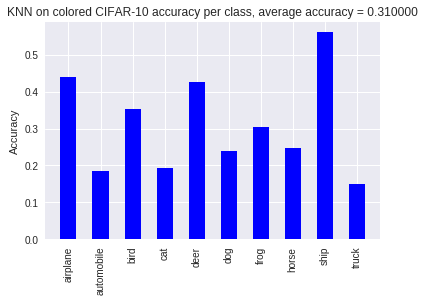

In [18]:
xtr, xgtr, ytr, xte, xgte, yte, names = load_cifar('cifar-10-batches-py')
xtr=xtr[:20000]
ytr=ytr[:20000]
xte=xte[:10000]
yte=yte[:10000]
# best_k and best_l from cross-validation are k=1 and L1
best_k = 1
best_l = 'L2'
train_and_predict(xtr, ytr, xte, yte, best_k, best_l, 'colored', names)
#train_and_predict(xgtr, ytr, xgte, yte, best_k, best_l, 'grayscale', names)